# Loading Datasets Notebook

In [1]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join("", "..")))
import torch
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from lora_w2w import LoRAw2w
from utils import unflatten
from diffusers import DiffusionPipeline 
from peft import PeftModel
from peft.utils.save_and_load import load_peft_weights
device = "cuda:0"

## Load Files

1) weight_dimensions is a dictionary of the dimensionality for each LoRA in the UNet. Used to save models in Diffusers pipeline format. 

In [2]:
weight_dimensions = torch.load("../files/weight_dimensions.pt")

# Loading a Model from the Dataset of Weights

We load a model from the tensor of flattened LoRas, then call the "unflatten" function which unflattens the weights into LoRA modules and saves them in Diffusers Pipeline format. The same setup works for the dataset of dog-encoding models as well.

In [4]:
#### get model with index 8 from dataset of model weights
model = torch.load("../weights_datasets/identities/all_weights.pt")[8, :].unsqueeze(0).clone().to(device)
unflatten(model, weight_dimensions, "../example")

In [5]:
pipe = DiffusionPipeline.from_pretrained("stablediffusionapi/realistic-vision-v51", 
                                         torch_dtype=torch.float16,safety_checker = None,
                                         requires_safety_checker = False).to(device)
   
pipe.unet = PeftModel.from_pretrained(pipe.unet, "../example/unet", adapter_name="identity1")
adapters_weights1 = load_peft_weights("../example/unet", device="cuda:0")
pipe.unet.load_state_dict(adapters_weights1, strict = False)
pipe.to(device)
print("")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

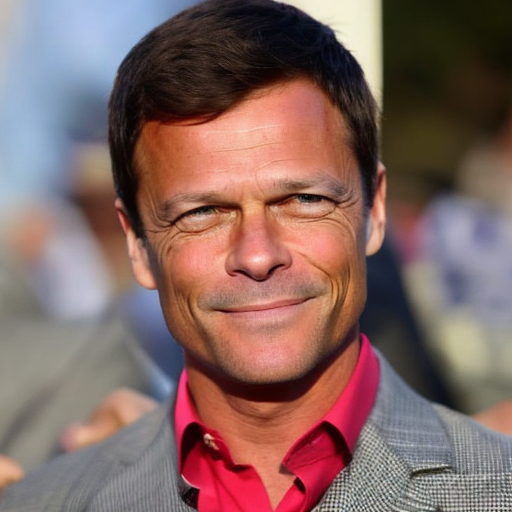

In [6]:
#random seed generator
generator = torch.Generator(device=device)
generator = generator.manual_seed(5)
latents = torch.randn(
        (1, pipe.unet.in_channels, 512 // 8, 512 // 8),
        generator = generator,
        device = device
    ).half()

#inference parameters
prompt = "sks person"
negative_prompt = "low quality, blurry, unfinished"
guidance_scale = 3.0
ddim_steps = 50
#run inference
image = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
image